# **Wave-U-Net for Background Noise Suppression**

**Signal Processing for Artificial Intelligence in Audio - Final Project**

Yuval Sheinin

A.C

O.N

---

*Note to reader: This notebook was completed collaboratively across several Google Drive environments, for this reason path names are not consistent across cells.*


# Outline

- Dataset:
  * Includes all types of noises.
  * Noise level set to 20dB only.
  * Training dataset composed of train_speech and train_noise; mixing performed.

- Model:
  * Fine-tuning of U-Net applied to all layers: downsampling and upsampling.


- Goals:
  * Assess the model's SNR performance. Experiment with reducing background noise on different SNR values and  noise types.

# Imports

In [ ]:
# Imports
import zipfile
import os
import csv
import librosa
import re
import sys
import pdb
import random
import shutil
import json
import subprocess
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Setting Up Environment and Dependencies

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Necessary installation for notebook running
!pip3 install future
!pip3 install numpy
!pip3 install librosa
!pip3 install soundfile
!pip3 install musdb
!pip3 install museval
!pip3 install h5py
!pip3 install tqdm
!pip3 install torch
!pip3 install torchvision
!pip3 install tensorboard
!pip3 install sortedcontainers
!pip3 install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
### Necessary installations for Wave-U-Net-PyTorch

# Install the necessary system packages
!apt-get install ffmpeg libsndfile1

# Install dependencies from requirements.txt
!pip3 install -r "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/requirements.txt"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6

In [ ]:
### Github Cloning

# Change directory to the desired path in Google Drive
%cd /content/drive/MyDrive/Reichman University /AI Audio/Final Project

# Clone the MS-SNSD GitHub repository
!git clone https://github.com/microsoft/MS-SNSD.git

# Clone the Wave-U-Net-Pytorch repository from GitHub
!git clone https://github.com/f90/Wave-U-Net-Pytorch.git

/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part
fatal: destination path 'MS-SNSD' already exists and is not an empty directory.
fatal: destination path 'Wave-U-Net-Pytorch' already exists and is not an empty directory.


# Create Dataset

 Run Microsoft code for creating the Noisy files

In [ ]:
noisy_speech_training_dir = r"/content/drive/My Drive/Reichman University /AI Audio/Final Project/MS-SNSD/NoisySpeech_training"

## Create Training Set

In [ ]:
if os.path.exists(noisy_speech_training_dir):
    print("NoisySpeech_training directory found. The script will not be executed.")
else:
    # Run the noisyspeech_synthesizer script directly by specifying the full path.
    # This script utilizes a synthesizer to generate three types of training data: clean_speech_training, noise_training, and noisy_speech_training.
    # - clean_speech_training consists of recordings of clean speech used for training.
    # - noise_training consists of noise samples used for training. Each clean speech recording is paired with a specified number of noise samples based on the configuration requirements.
    #   For example, if the configuration specifies five noise samples for each clean speech recording, then in noisy_speech_training, each clean speech recording will be paired with five noise samples.
    #   Therefore, if we have 60 clean speech recordings and a parameter of five, noisy_speech_training will include 300 records, each containing one clean speech recording mixed with five noise samples.
    !python "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/MS-SNSD/noisyspeech_synthesizer.py" --cfg noisyspeech_synthesizer_train.cfg


NoisySpeech_training directory found. The script will not be executed.


## Create Test Set

In [ ]:
if os.path.exists(noisy_speech_training_dir):
    print("NoisySpeech_training directory found. The script will not be executed.")
else:
    # Run the noisyspeech_synthesizer script directly by specifying the full path.
    # This script utilizes a synthesizer to generate three types of training data: clean_speech_training, noise_training, and noisy_speech_training.
    # - clean_speech_training consists of recordings of clean speech used for training.
    # - noise_training consists of noise samples used for training. Each clean speech recording is paired with a specified number of noise samples based on the configuration requirements.
    #   For example, if the configuration specifies five noise samples for each clean speech recording, then in noisy_speech_training, each clean speech recording will be paired with five noise samples.
    #   Therefore, if we have 60 clean speech recordings and a parameter of five, noisy_speech_training will include 300 records, each containing one clean speech recording mixed with five noise samples.
    !python "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/MS-SNSD/noisyspeech_synthesizer.py" --cfg noisyspeech_synthesizer_test.cfg


## Organize the Data to Look Like Musdb18hq

In [ ]:
# Define Constants
NUM_OF_SNR_LEVELS = 1  # Number of SNR levels
AUDIO_FILE_TYPE = '.wav'  # File extension for audio files

def create_sample(sample_num, clean_file, noise_file, dataset_type, dataset_path, clean_speech_path, noise_path, noisy_speech_path):
    # Create sample folder
    sample_folder = f"{os.path.splitext(noise_file)[0]}_{os.path.splitext(clean_file)[0]}"
    sample_path = os.path.join(dataset_path, dataset_type, sample_folder)
    os.makedirs(sample_path)

    # Load clean speech files (loaded as mono by default)
    clean_audio, sr = librosa.load(os.path.join(clean_speech_path, clean_file), sr=None, mono=True)
    # Convert clean audio to stereo by duplicating across channels
    clean_audio_stereo = np.vstack([clean_audio, clean_audio])
    # Write the stereo clean audio to the vocals file
    sf.write(os.path.join(sample_path, "vocals.wav"), clean_audio_stereo.T, sr)

    # Create noisy speech filename based on clean and noise filenames
    noisy_speech_filename = f"{noise_file}_{clean_file}"
    noisy_speech_filename = noisy_speech_filename.replace(".wav", "") + AUDIO_FILE_TYPE

    # Load noisy speech files (loaded as mono by default)
    noisy_speech, sr = librosa.load(os.path.join(noisy_speech_path, noisy_speech_filename), sr=None, mono=True)
    # Convert noisy audio to stereo by duplicating across channels
    noisy_audio_stereo = np.vstack([noisy_speech, noisy_speech])
    # Write the stereo noisy audio to the mixture file
    sf.write(os.path.join(sample_path, "mixture.wav"), noisy_audio_stereo.T, sr)

    # Load noise file (loaded as mono by default)
    noise_audio, sr = librosa.load(os.path.join(noise_path, noise_file), sr=None, mono=True)
    # Convert noise audio to stereo by duplicating across channels
    noise_audio_stereo = np.vstack([noise_audio, noise_audio])
    # Write the stereo noise audio to other, bass, and drums files
    sf.write(os.path.join(sample_path, "other.wav"), noise_audio_stereo.T, sr)
    sf.write(os.path.join(sample_path, "bass.wav"), noise_audio_stereo.T, sr)
    sf.write(os.path.join(sample_path, "drums.wav"), noise_audio_stereo.T, sr)

def process_samples(dataset_path, clean_speech_path, noisy_speech_path,  noise_path, dataset_type):

    # Check if the dataset folder is empty
    if not os.path.exists(os.path.join(dataset_path, dataset_type)):
        # Create a folder for train or test based on the argument provided
        dataset_type_folder = os.path.join(dataset_path, dataset_type)

        # Create a folder for the dataset type
        os.makedirs(dataset_type_folder)

        clean_files = [file for file in os.listdir(clean_speech_path) if file.startswith("clnsp")]

        # Calculate the Total Number of Samples (N)
        num_of_clean_samples = len(clean_files)
        N = NUM_OF_SNR_LEVELS * num_of_clean_samples
        print("Total Number of Samples (N):", N)

        # Initialize sample counter
        num_of_sample = 1

        # Iterate through clean speech files and match with noise files
        for clean_file in clean_files:
            clean_number_match = re.match(r'clnsp(\d+).*\.wav$', clean_file)
            clean_number = int(clean_number_match.group(1))
            filtered_noise_files = [file for file in os.listdir(noise_path) if file.startswith(f"noisy{clean_number}_")]

            for noise_file in filtered_noise_files:
                create_sample(num_of_sample, clean_file, noise_file, dataset_type,
                              dataset_path, clean_speech_path, noise_path, noisy_speech_path)
                print("Number of Samples Processed:", num_of_sample)
                num_of_sample += 1
    else:
        print("Dataset_type folder already exists. Exiting...")

In [ ]:
# Define Paths to Source Directories
clean_speech_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/MS-SNSD/CleanSpeech_training"
noisy_speech_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/MS-SNSD/NoisySpeech_training"
noise_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/MS-SNSD/Noise_training"
# Define Path to Destination Dataset
dataset_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Dataset"


In [ ]:
# Run the script
process_samples(dataset_path, clean_speech_path, noisy_speech_path, noise_path, 'train')

Total Number of Samples (N): 768
Number of Samples Processed: 1
Number of Samples Processed: 2
Number of Samples Processed: 3
Number of Samples Processed: 4
Number of Samples Processed: 5
Number of Samples Processed: 6
Number of Samples Processed: 7
Number of Samples Processed: 8
Number of Samples Processed: 9
Number of Samples Processed: 10
Number of Samples Processed: 11
Number of Samples Processed: 12
Number of Samples Processed: 13
Number of Samples Processed: 14
Number of Samples Processed: 15
Number of Samples Processed: 16
Number of Samples Processed: 17
Number of Samples Processed: 18
Number of Samples Processed: 19
Number of Samples Processed: 20
Number of Samples Processed: 21
Number of Samples Processed: 22
Number of Samples Processed: 23
Number of Samples Processed: 24
Number of Samples Processed: 25
Number of Samples Processed: 26
Number of Samples Processed: 27
Number of Samples Processed: 28
Number of Samples Processed: 29
Number of Samples Processed: 30
Number of Sample

In [ ]:
# Run the script
process_samples(dataset_path, clean_speech_path, noisy_speech_path, noise_path, 'test')

Total Number of Samples (N): 190
Number of Samples Processed: 1
Number of Samples Processed: 2
Number of Samples Processed: 3
Number of Samples Processed: 4
Number of Samples Processed: 5
Number of Samples Processed: 6
Number of Samples Processed: 7
Number of Samples Processed: 8
Number of Samples Processed: 9
Number of Samples Processed: 10
Number of Samples Processed: 11
Number of Samples Processed: 12
Number of Samples Processed: 13
Number of Samples Processed: 14
Number of Samples Processed: 15
Number of Samples Processed: 16
Number of Samples Processed: 17
Number of Samples Processed: 18
Number of Samples Processed: 19
Number of Samples Processed: 20
Number of Samples Processed: 21
Number of Samples Processed: 22
Number of Samples Processed: 23
Number of Samples Processed: 24
Number of Samples Processed: 25
Number of Samples Processed: 26
Number of Samples Processed: 27
Number of Samples Processed: 28
Number of Samples Processed: 29
Number of Samples Processed: 30
Number of Sample

## Shuffle

Shuffle original data and create new train and test directories. This allows for a more robust training of the model, while avoiding data leakage.  

In [ ]:
# Constants
START_NUM = 769
SNRDB_VALUE = 20.0  # Default SNRdb value


def rename_test_subdirectories(test_dir, start_num, snrdb_value):
    """
    Rename test subdirectories based on specified naming conventions.
    """
    sorted_subdirs = sorted(os.listdir(test_dir), key=lambda x: int(x.split('noisy')[1].split('_')[0]))

    for index, subdir in enumerate(sorted_subdirs, start=start_num):
        old_path = os.path.join(test_dir, subdir)
        new_dir_name = f"noisy{index}_SNRdb_{snrdb_value}_clnsp{index}"
        new_path = os.path.join(test_dir, new_dir_name)
        os.rename(old_path, new_path)


def list_subfolder_names(directory):
    """
    List subfolder names in the specified directory.
    """
    subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    return subfolders


def reorganize_folders(src_folder, dest_folder, subdir_list):
    """
    Move subdirectories from source to destination based on the provided list.
    """
    os.makedirs(dest_folder, exist_ok=True)

    for item in os.listdir(src_folder):
        item_path = os.path.join(src_folder, item)

        if os.path.isdir(item_path) and item not in subdir_list:
            dest_path = os.path.join(dest_folder, item)
            shutil.move(item_path, dest_path)


def combine_and_split_dataset(base_directory, test_size=0.2):
    """
    Combine and split dataset into train and test sets.
    """
    train_dir = os.path.join(base_directory, 'train')
    test_dir = os.path.join(base_directory, 'test')

    rename_test_subdirectories(test_dir, START_NUM, SNRDB_VALUE)

    train_subfolders = list_subfolder_names(train_dir)
    test_subfolders = list_subfolder_names(test_dir)

    all_subfolders = train_subfolders + test_subfolders
    all_subfolders_shuffled = shuffle(all_subfolders)

    train_subdirs, test_subdirs = train_test_split(all_subfolders_shuffled, test_size=test_size)

    reorganize_folders(train_dir, test_dir, train_subdirs)
    reorganize_folders(test_dir, train_dir, test_subdirs)


if __name__ == "__main__":
    data_dir = "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/Dataset"
    PROTECT = 1
    if PROTECT == 1:
        print('Sorry, the data is protected.')
    else:
        combine_and_split_dataset(data_dir, test_size=0.2)

Sorry, the data is protected.


# Train (Fine tune)

In [ ]:
!python "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/train.py" --dataset_dir "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/Dataset" --load_model "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet/model" --checkpoint_dir "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet" --hdf_dir "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/hdf" --log_dir "/content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/logs/waveunet" --patience 5 --sr 16000 --channels 2 --cuda


2024-03-14 16:48:40.923666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 16:48:40.923902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 16:48:41.057195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 16:48:41.146371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 16:48:43.433561: W tensorflow/compiler/tf2

## Loss Graphs (Training and Validation)

In [ ]:
def plot_loss(train_loss_file, val_loss_file, model_type):
    """
    Plots the training and validation loss from two JSON files.
    """

    # Load train_loss.json
    with open(train_loss_file, 'r') as f:
        train_losses = json.load(f)

    # Load val_loss.json
    with open(val_loss_file, 'r') as f:
        val_losses = json.load(f)

    # Create epochs list
    epochs = list(range(1, len(train_losses) + 1))  # Assuming the number of epochs equals the length of the losses list

    # Plotting
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss \n {model_type}')

    # Add legend
    plt.legend()

    # Add grid
    plt.grid(True)

    # Show plot
    plt.show()


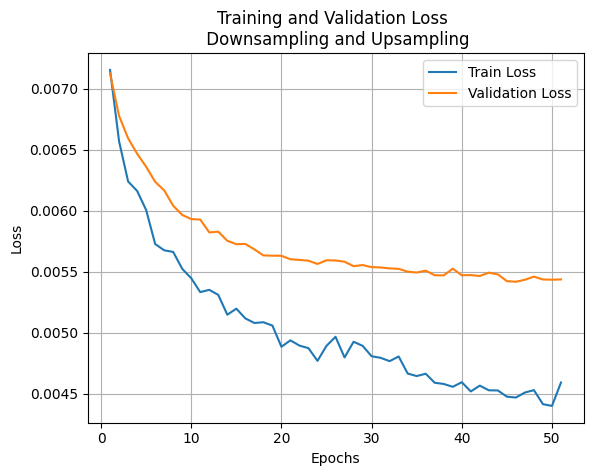

In [ ]:
train_loss_file = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/logs/waveunet/Train_Val_Test_FT_ALL/train_loss.json"
val_loss_file = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/logs/waveunet/Train_Val_Test_FT_ALL/val_loss.json"

plot_loss(train_loss_file, val_loss_file, 'Downsampling and Upsampling')

Here, we observe fine-tuning applied to all weights across every layer within the specified Wave-U-Net model.

## Predict Results for Fine Tuning

Run prediction code on entire test folder:

In [ ]:
# Define the model path
model_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/checkpoint_137012"

# Define the test directory path
test_dir = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Dataset/test"

# Define the output directory path
output_dir = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Predict"

# Check if the output directory is empty
if not os.listdir(output_dir):
    # Iterate over the test files in the test directory
    for test_file in os.listdir(test_dir):

        test_file_name = 'mixture.wav'

        # Extract the test file name
        test_file_path = os.path.join(test_dir, test_file, test_file_name)

        # Create directory for the current test file's predictions
        test_output_dir = os.path.join(output_dir, test_file + "_predict")
        os.makedirs(test_output_dir, exist_ok=True)

        # Construct the command
        command = f"python \"/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/predict.py\" --load_model \"{model_path}\" --input \"{test_file_path}\" --output \"{test_output_dir}\" --sr 16000 --cuda"

        # Execute the command
        !{command}

else:
    print("Predict directory is not empty. Please clear the directory before running predictions.")


Using valid convolutions with 41641 inputs and 32089 outputs
move model to gpu
Loading model from checkpoint /content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet/checkpoint_137012
Step 137012
Using valid convolutions with 41641 inputs and 32089 outputs
move model to gpu
Loading model from checkpoint /content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet/checkpoint_137012
Step 137012
Using valid convolutions with 41641 inputs and 32089 outputs
move model to gpu
Loading model from checkpoint /content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet/checkpoint_137012
Step 137012
Using valid convolutions with 41641 inputs and 32089 outputs
move model to gpu
Loading model from checkpoint /content/drive/MyDrive/Semester 1/AudioProcAndAI/Final Project/Practical Part/Wave-U-Net-Pytorch/checkpoints/waveunet/ch

## Evaluate Model Using SNR

In [ ]:
def calc_SNR(speech, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) between speech and noise signals.

    Args:
    - speech (numpy.ndarray): Array containing speech signal.
    - noise (numpy.ndarray): Array containing noise signal.

    Returns:
    - snr (float): Signal-to-Noise Ratio (SNR) in decibels (dB).
    """

    # Calculate the power of the noise signal
    power_noise = np.mean(noise ** 2)

    # Print the power of the noise signal (optional)
    # print(power_noise)

    # Define the threshold for detecting non-silent segments in the speech audio
    silence_threshold = 1.1 * np.median(np.abs(noise))  # Adjust this threshold as needed

    # Find indices of non-silent segments in the speech audio
    non_silent_indices = np.where(speech ** 2 > silence_threshold)

    # Calculate the power of non-silent speech segments
    power_non_silent_speech = np.mean(speech[non_silent_indices] ** 2)

    # Print the power of non-silent speech segments (optional)
    # print(power_non_silent_speech)

    # Calculate SNR in decibels (dB)
    snr = 10 * np.log10(power_non_silent_speech / power_noise)

    # Print SNR (optional)
    # print(snr)

    return snr

In [ ]:
# Define the folder path containing audio files
predict_folder_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Predict"
test_dataset_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Dataset/test"

# Initialize total SNR, max SNR, min SNR, and length of the folder
total_SNR = 0
max_SNR = float('-inf')
min_SNR = float('inf')
SNR_values = []

length = len(os.listdir(predict_folder_path))
progress = 0

# Iterate through each audio file in the folder
for folder_name in os.listdir(predict_folder_path):
    # Remove the "_predict" part
    folder_name_without_predict = folder_name[:-8]

    # Load the audio files
    predicted_speech, sample_rate_predict = librosa.load(os.path.join(predict_folder_path, folder_name, 'mixture_vocals.wav'), sr=None)
    test_clean_speech, sample_rate_test = librosa.load(os.path.join(test_dataset_path, folder_name_without_predict, 'vocals.wav'), sr=None)

    # Calculate estimated noise by subtracting original clean speech from predicted speech
    est_result_noise = predicted_speech - test_clean_speech

    # Calculate SNR for the current audio file
    curr_SNR = calc_SNR(test_clean_speech, est_result_noise)

    # Accumulate SNR for mean calculation
    total_SNR += curr_SNR

    # Update max and min SNR
    max_SNR = max(max_SNR, curr_SNR)
    min_SNR = min(min_SNR, curr_SNR)

    # Append current SNR to the list
    SNR_values.append(curr_SNR)

    progress += 1  # Increment progress counter
    progress_percentage = (progress / length) * 100  # Calculate progress percentage
    print(f"Progress: {progress}/{length} ({progress_percentage:.2f}%)")  # Print progress

# Calculate mean SNR
mean_SNR = total_SNR / length

# Calculate median SNR
median_SNR = np.median(SNR_values)

# Print the mean, max, min, and median SNR
print('\n')
print('THE MEAN SNR IS: ', mean_SNR)
print('THE MAX SNR IS: ', max_SNR)
print('THE MIN SNR IS: ', min_SNR)
print('THE MEDIAN SNR IS: ', median_SNR)

Progress: 1/46 (2.17%)
Progress: 2/46 (4.35%)
Progress: 3/46 (6.52%)
Progress: 4/46 (8.70%)
Progress: 5/46 (10.87%)
Progress: 6/46 (13.04%)
Progress: 7/46 (15.22%)
Progress: 8/46 (17.39%)
Progress: 9/46 (19.57%)
Progress: 10/46 (21.74%)
Progress: 11/46 (23.91%)
Progress: 12/46 (26.09%)
Progress: 13/46 (28.26%)
Progress: 14/46 (30.43%)
Progress: 15/46 (32.61%)
Progress: 16/46 (34.78%)
Progress: 17/46 (36.96%)
Progress: 18/46 (39.13%)
Progress: 19/46 (41.30%)
Progress: 20/46 (43.48%)
Progress: 21/46 (45.65%)
Progress: 22/46 (47.83%)
Progress: 23/46 (50.00%)
Progress: 24/46 (52.17%)
Progress: 25/46 (54.35%)
Progress: 26/46 (56.52%)
Progress: 27/46 (58.70%)
Progress: 28/46 (60.87%)
Progress: 29/46 (63.04%)
Progress: 30/46 (65.22%)
Progress: 31/46 (67.39%)
Progress: 32/46 (69.57%)
Progress: 33/46 (71.74%)
Progress: 34/46 (73.91%)
Progress: 35/46 (76.09%)
Progress: 36/46 (78.26%)
Progress: 37/46 (80.43%)
Progress: 38/46 (82.61%)
Progress: 39/46 (84.78%)
Progress: 40/46 (86.96%)
Progress: 41/

# Experimenting with the Model

## Experiment One: SNR Robustness Check
Start by generating data with different SNR values

In [ ]:
# generate SNR 10
!python3 "/content/drive/MyDrive/SoundAI - Final/MS-SNSD/noisyspeech_synthesizer_10_SNR.py" --cfg noisyspeech_synthesizer_10_SNR.cfg

# generate SNR 5
!python3 "/content/drive/MyDrive/SoundAI - Final/MS-SNSD/noisyspeech_synthesizer_5_SNR.py" --cfg noisyspeech_synthesizer_5_SNR.cfg

# generate SNR 0
!python3 "/content/drive/MyDrive/SoundAI - Final/MS-SNSD/noisyspeech_synthesizer_0_SNR.py" --cfg noisyspeech_synthesizer_0_SNR.cfg


Edit the MS-SNSD data to look like the MUSDB18 data

In [ ]:
def run_process_samples_for_snr_levels(snr_dict, dataset_type):
    for snr_level, paths in snr_dict.items():
        # Extract paths for the current SNR level
        noisy_speech_path, clean_speech_path, noise_path, dataset_path = paths

        print(f"Processing {snr_level}: clean_path={clean_speech_path}, noisy_path={noisy_speech_path}, noise_path={noise_path}, dataset_path={dataset_path}")

        # Call process_samples with the extracted paths and the dataset type for the current SNR level
        process_samples(dataset_path, clean_speech_path, noisy_speech_path, noise_path, dataset_type)



In [ ]:
destination_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
data_base_path = "/content/drive/MyDrive/SoundAI - Final/MS-SNSD"

snr_dirs = [os.path.join(data_base_path, snr) for snr in ['SNR_0', 'SNR_5', 'SNR_10']]
destination_paths = [os.path.join(destination_base_path, snr) for snr in ['SNR_0', 'SNR_5', 'SNR_10']]

# Generate SNR paths
snr_paths = [[os.path.join(snr_dir, dir) for dir in os.listdir(snr_dir)] + [destination] for snr_dir, destination in zip(snr_dirs, destination_paths)]

# Creating a dictionary to map SNR levels to their respective paths
snr_dict = dict(zip(['SNR_0', 'SNR_5', 'SNR_10'], snr_paths))


In [ ]:
run_process_samples_for_snr_levels(snr_dict, 'test')

Processing SNR_0: clean_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_0/CleanSpeech_training, noisy_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_0/NoisySpeech_training, noise_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_0/Noise_training, dataset_path=/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset/SNR_0
Dataset_type folder already exists. Exiting...
Processing SNR_5: clean_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_5/CleanSpeech_training, noisy_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_5/NoisySpeech_training, noise_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_5/Noise_training, dataset_path=/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset/SNR_5
Dataset_type folder already exists. Exiting...
Processing SNR_10: clean_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_10/CleanSpeech_training, noisy_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/SNR_10/NoisySpeech_training, noi

 Predict each SNR value using FT_ALL, trained on 20SNR

In [ ]:
def run_prediction(path_to_predict, model_path, test_file_path, test_output_dir):
    command = [
        "python", path_to_predict,
        "--load_model", model_path,
        "--input", test_file_path,
        "--output", test_output_dir,
        "--sr", "16000"
        # "--cuda"  # Uncomment if CUDA is to be used
    ]
    subprocess.run(command, check=True)

def predict_snr_level(path_to_predict, model_path, test_dir, output_dir):
    """
    Process an SNR level by running predictions on the test files and saving the results in the output directory.

    :param model_path: Path to the model checkpoint.
    :param test_dir: Directory containing test files for an SNR level.
    :param output_dir: Directory where predictions will be saved for an SNR level.
    """
    os.makedirs(output_dir, exist_ok=True)
    for test_file in os.listdir(test_dir):
        test_file_path = os.path.join(test_dir, test_file, 'mixture.wav')
        if os.path.exists(test_file_path):
            test_output_dir = os.path.join(output_dir, test_file + "_predict")
            os.makedirs(test_output_dir, exist_ok=True)
            try:
                run_prediction(path_to_predict, model_path, test_file_path, test_output_dir)
            except subprocess.CalledProcessError as e:
                print(f"Error during processing {test_file_path}: {e}")
        else:
            print(f"Skipping {test_file_path}, file not found.")

def process_all_snr_levels(path_to_predict, model_path, snr_levels, base_dataset_dir, base_output_dir):
    """
    Process all given SNR levels.

    :param model_path: Path to the model checkpoint.
    :param snr_levels: List of SNR levels to process.
    :param base_dataset_dir: Base directory containing SNR subdirectories for the dataset.
    :param base_output_dir: Base directory where SNR subdirectories for predictions will be created.
    """
    for snr in snr_levels:
        test_dir = os.path.join(base_dataset_dir, snr, "test")
        output_dir = os.path.join(base_output_dir, snr)
        predict_snr_level(path_to_predict, model_path, test_dir, output_dir)


In [ ]:
model_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/checkpoints/FT_ALL/model"
base_dataset_dir = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
base_output_dir = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Predict"
path_to_predict = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/predict.py"
snr_levels = ['SNR_0', 'SNR_5', 'SNR_10']

process_all_snr_levels(path_to_predict, model_path, snr_levels, base_dataset_dir, base_output_dir)

Evaluate the models performance on lower SNR values

In [ ]:
def calc_SNR(speech, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) between speech and noise signals.

    Args:
    - speech (numpy.ndarray): Array containing speech signal.
    - noise (numpy.ndarray): Array containing noise signal.

    Returns:
    - snr (float): Signal-to-Noise Ratio (SNR) in decibels (dB).
    """

    # Calculate the power of the noise signal
    power_noise = np.mean(noise ** 2)

    # Print the power of the noise signal (optional)
    # print(power_noise)

    # Define the threshold for detecting non-silent segments in the speech audio
    silence_threshold = 1.1 * np.median(np.abs(noise))  # Adjust this threshold as needed

    # Find indices of non-silent segments in the speech audio
    non_silent_indices = np.where(speech ** 2 > silence_threshold)

    # Calculate the power of non-silent speech segments
    power_non_silent_speech = np.mean(speech[non_silent_indices] ** 2)

    # Print the power of non-silent speech segments (optional)
    # print(power_non_silent_speech)

    # Calculate SNR in decibels (dB)
    snr = 10 * np.log10(power_non_silent_speech / power_noise)

    # Print SNR (optional)
    # print(snr)

    return snr

def process_SNR_calculation(predict_base_path, test_base_path, snr_values):
    snr_results = {}

    for snr in snr_values:
        predict_folder_path = os.path.join(predict_base_path, snr)
        test_folder_path = os.path.join(test_base_path, snr, 'test')

        total_SNR, max_SNR, min_SNR = 0, float('-inf'), float('inf')
        SNR_values, progress = [], 0

        for folder_name in os.listdir(predict_folder_path):
            predicted_file_path = os.path.join(predict_folder_path, folder_name, 'mixture_vocals.wav')
            test_file_path = os.path.join(test_folder_path, folder_name.replace('_predict', ''), 'vocals.wav')

            if os.path.exists(predicted_file_path) and os.path.exists(test_file_path):
                predicted_speech, _ = librosa.load(predicted_file_path, sr=None)
                test_clean_speech, _ = librosa.load(test_file_path, sr=None)

                est_noise = predicted_speech - test_clean_speech
                curr_SNR = calc_SNR(test_clean_speech, est_noise)

                total_SNR += curr_SNR
                max_SNR = max(max_SNR, curr_SNR)
                min_SNR = min(min_SNR, curr_SNR)
                SNR_values.append(curr_SNR)

                progress += 1
                print(f"Processing {folder_name} in {snr}: SNR = {curr_SNR:.2f} dB")

        # Aggregate results for current SNR
        mean_SNR = total_SNR / progress if progress else 0
        median_SNR = np.median(SNR_values) if SNR_values else 0

        # Store results in dictionary
        snr_results[snr] = {
            'mean_SNR': mean_SNR,
            'max_SNR': max_SNR,
            'min_SNR': min_SNR,
            'median_SNR': median_SNR
        }

    return snr_results


In [ ]:
predict_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Predict"
test_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
snr_values = ['SNR_0', 'SNR_5', 'SNR_10']

snr_results = process_SNR_calculation(predict_base_path, test_base_path, snr_values)

# Print the results
for snr, results in snr_results.items():
    print(f"Results for {snr}:")
    print(f"Mean SNR: {results['mean_SNR']} dB")
    print(f"Max SNR: {results['max_SNR']} dB")
    print(f"Min SNR: {results['min_SNR']} dB")
    print(f"Median SNR: {results['median_SNR']} dB")
    print("\n")

Processing noisy1_SNRdb_0.0_clnsp1_predict in SNR_0: SNR = 14.57 dB
Processing noisy2_SNRdb_0.0_clnsp2_predict in SNR_0: SNR = 13.38 dB
Processing noisy3_SNRdb_0.0_clnsp3_predict in SNR_0: SNR = 15.43 dB
Processing noisy4_SNRdb_0.0_clnsp4_predict in SNR_0: SNR = 18.43 dB
Processing noisy5_SNRdb_0.0_clnsp5_predict in SNR_0: SNR = 15.97 dB
Processing noisy6_SNRdb_0.0_clnsp6_predict in SNR_0: SNR = 17.95 dB
Processing noisy7_SNRdb_0.0_clnsp7_predict in SNR_0: SNR = 16.40 dB
Processing noisy8_SNRdb_0.0_clnsp8_predict in SNR_0: SNR = 11.65 dB
Processing noisy9_SNRdb_0.0_clnsp9_predict in SNR_0: SNR = 14.46 dB
Processing noisy10_SNRdb_0.0_clnsp10_predict in SNR_0: SNR = 13.48 dB
Processing noisy11_SNRdb_0.0_clnsp11_predict in SNR_0: SNR = 18.00 dB
Processing noisy12_SNRdb_0.0_clnsp12_predict in SNR_0: SNR = 14.77 dB
Processing noisy13_SNRdb_0.0_clnsp13_predict in SNR_0: SNR = 16.15 dB
Processing noisy14_SNRdb_0.0_clnsp14_predict in SNR_0: SNR = 11.85 dB
Processing noisy15_SNRdb_0.0_clnsp15_p

## Experiment Two: Verifying Specific Background Noises

Isolating and comparing model performance on different background noises

In [ ]:
# generate files with typing as a background noise only
!python3 "/content/drive/MyDrive/SoundAI - Final/MS-SNSD/noisyspeech_synthesizer_typing.py" --cfg noisyspeech_synthesizer_typing.cfg

# generate files with airport announcements as a background noise only
!python3 "/content/drive/MyDrive/SoundAI - Final/MS-SNSD/noisyspeech_synthesizer_airport.py" --cfg noisyspeech_synthesizer_airport_announcement.cfg

In [ ]:
destination_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
data_base_path = "/content/drive/MyDrive/SoundAI - Final/MS-SNSD"

background_noise_dirs = [os.path.join(data_base_path, background_noise) for background_noise in ['AirportAnnouncement', 'Typing']]
destination_paths = [os.path.join(destination_base_path, background_noise) for background_noise in ['AirportAnnouncement', 'Typing']]

# Generate background noise paths
background_noise_paths = [[os.path.join(background_noise_dirs, dir) for dir in os.listdir(background_noise_dirs)] + [destination] for background_noise_dirs, destination in zip(background_noise_dirs, destination_paths)]

# Creating a dictionary to map background noises to their respective paths
background_noise_dict = dict(zip(['AirportAnnouncement', 'Typing'], background_noise_paths))


In [ ]:
background_noise_dict

{'AirportAnnouncement': ['/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/NoisySpeech_training',
  '/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/CleanSpeech_training',
  '/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/Noise_training',
  '/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset/AirportAnnouncement'],
 'Typing': ['/content/drive/MyDrive/SoundAI - Final/MS-SNSD/Typing/NoisySpeech_training',
  '/content/drive/MyDrive/SoundAI - Final/MS-SNSD/Typing/CleanSpeech_training',
  '/content/drive/MyDrive/SoundAI - Final/MS-SNSD/Typing/Noise_training',
  '/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset/Typing']}

In [ ]:
def run_process_samples_for_background_noise(background_noise_dict, dataset_type):
    for background_noise, paths in background_noise_dict.items():
        # Extract paths for the current SNR level
        noisy_speech_path, clean_speech_path, noise_path, dataset_path = paths

        print(f"Processing {background_noise}: clean_path={clean_speech_path}, noisy_path={noisy_speech_path}, noise_path={noise_path}, dataset_path={dataset_path}")

        # Call process_samples with the extracted paths and the dataset type for the current SNR level
        process_samples(dataset_path, clean_speech_path, noisy_speech_path, noise_path, dataset_type)

In [ ]:
run_process_samples_for_background_noise(background_noise_dict, 'test')

Processing AirportAnnouncement: clean_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/CleanSpeech_training, noisy_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/NoisySpeech_training, noise_path=/content/drive/MyDrive/SoundAI - Final/MS-SNSD/AirportAnnouncement/Noise_training, dataset_path=/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset/AirportAnnouncement
Total Number of Samples (N): 24
Number of Samples Processed: 1
Number of Samples Processed: 2
Number of Samples Processed: 3
Number of Samples Processed: 4
Number of Samples Processed: 5
Number of Samples Processed: 6
Number of Samples Processed: 7
Number of Samples Processed: 8
Number of Samples Processed: 9
Number of Samples Processed: 10
Number of Samples Processed: 11
Number of Samples Processed: 12
Number of Samples Processed: 13
Number of Samples Processed: 14
Number of Samples Processed: 15
Number of Samples Processed: 16
Number of Samples Processed: 17
Number o

In [ ]:
model_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/checkpoints/FT_ALL/model"
base_dataset_dir = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
base_output_dir = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Predict"
path_to_predict = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/predict.py"
background_noises = ['AirportAnnouncement', 'Typing']

process_all_snr_levels(path_to_predict, model_path, background_noises, base_dataset_dir, base_output_dir)

In [ ]:
def process_SNR_calculation_background_noise(predict_base_path, test_base_path, background_noises):
    background_noises_results = {}

    for background_noise in background_noises:
        predict_folder_path = os.path.join(predict_base_path, background_noise)
        test_folder_path = os.path.join(test_base_path, background_noise, 'test')

        total_SNR, max_SNR, min_SNR = 0, float('-inf'), float('inf')
        SNR_values, progress = [], 0

        for folder_name in os.listdir(predict_folder_path):
            predicted_file_path = os.path.join(predict_folder_path, folder_name, 'mixture_vocals.wav')
            test_file_path = os.path.join(test_folder_path, folder_name.replace('_predict', ''), 'vocals.wav')

            if os.path.exists(predicted_file_path) and os.path.exists(test_file_path):
                predicted_speech, _ = librosa.load(predicted_file_path, sr=None)
                test_clean_speech, _ = librosa.load(test_file_path, sr=None)

                est_noise = predicted_speech - test_clean_speech
                curr_SNR = calc_SNR(test_clean_speech, est_noise)

                total_SNR += curr_SNR
                max_SNR = max(max_SNR, curr_SNR)
                min_SNR = min(min_SNR, curr_SNR)
                SNR_values.append(curr_SNR)

                progress += 1
                print(f"Processing {folder_name} in {background_noise}: SNR = {curr_SNR:.2f} dB")

        # Aggregate results for current SNR
        mean_SNR = total_SNR / progress if progress else 0
        median_SNR = np.median(SNR_values) if SNR_values else 0

        # Store results in dictionary
        background_noises_results[background_noise] = {
            'mean_SNR': mean_SNR,
            'max_SNR': max_SNR,
            'min_SNR': min_SNR,
            'median_SNR': median_SNR
        }

    return background_noises_results

In [ ]:
predict_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Predict"
test_base_path = "/content/drive/MyDrive/SoundAI - Final/Wave-U-Net-Pytorch/Dataset"
background_noises = ['AirportAnnouncement', 'Typing']

background_noises_results = process_SNR_calculation_background_noise(predict_base_path, test_base_path, background_noises)

# Print the results
for background_noise, results in background_noises_results.items():
    print(f"Results for {background_noise}:")
    print(f"Mean SNR: {results['mean_SNR']} dB")
    print(f"Max SNR: {results['max_SNR']} dB")
    print(f"Min SNR: {results['min_SNR']} dB")
    print(f"Median SNR: {results['median_SNR']} dB")
    print("\n")

Processing noisy1_SNRdb_20.0_clnsp1_predict in AirportAnnouncement: SNR = 19.81 dB
Processing noisy2_SNRdb_20.0_clnsp2_predict in AirportAnnouncement: SNR = 16.36 dB
Processing noisy3_SNRdb_20.0_clnsp3_predict in AirportAnnouncement: SNR = 17.53 dB
Processing noisy4_SNRdb_20.0_clnsp4_predict in AirportAnnouncement: SNR = 18.37 dB
Processing noisy5_SNRdb_20.0_clnsp5_predict in AirportAnnouncement: SNR = 18.84 dB
Processing noisy6_SNRdb_20.0_clnsp6_predict in AirportAnnouncement: SNR = 17.48 dB
Processing noisy7_SNRdb_20.0_clnsp7_predict in AirportAnnouncement: SNR = 18.93 dB
Processing noisy8_SNRdb_20.0_clnsp8_predict in AirportAnnouncement: SNR = 18.18 dB
Processing noisy9_SNRdb_20.0_clnsp9_predict in AirportAnnouncement: SNR = 17.85 dB
Processing noisy10_SNRdb_20.0_clnsp10_predict in AirportAnnouncement: SNR = 18.32 dB
Processing noisy11_SNRdb_20.0_clnsp11_predict in AirportAnnouncement: SNR = 18.68 dB
Processing noisy12_SNRdb_20.0_clnsp12_predict in AirportAnnouncement: SNR = 17.94 d

# Compare Results on Pre-Trained U-NET Model
Predict results for fine tuning on Pre-trained model, and evaluate using SNR.

In [ ]:
# Define the model path
model_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/model"

# Define the test directory path
test_dir = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Dataset/test"

# Define the output directory path
output_dir = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Predict-pre-trained"

# Check if the output directory is empty
if not os.listdir(output_dir):
    # Iterate over the test files in the test directory
    for test_file in os.listdir(test_dir):

        test_file_name = 'mixture.wav'

        # Extract the test file name
        test_file_path = os.path.join(test_dir, test_file, test_file_name)

        # Create directory for the current test file's predictions
        test_output_dir = os.path.join(output_dir, test_file + "_predict")
        os.makedirs(test_output_dir, exist_ok=True)

        # Construct the command
        command = f"python \"/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/predict.py\" --load_model \"{model_path}\" --input \"{test_file_path}\" --output \"{test_output_dir}\" --sr 16000"

        # Execute the command
        !{command}

else:
    print("Predict directory is not empty. Please clear the directory before running predictions.")


Using valid convolutions with 41641 inputs and 32089 outputs
Loading model from checkpoint /content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/model
Step 132065
Using valid convolutions with 41641 inputs and 32089 outputs
Loading model from checkpoint /content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/model
Step 132065
Using valid convolutions with 41641 inputs and 32089 outputs
Loading model from checkpoint /content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/model
Step 132065
Using valid convolutions with 41641 inputs and 32089 outputs
Loading model from checkpoint /content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/checkpoints/waveunet/model
Step 132065
Using valid convolutions with 41641 inputs and 32089 outputs
Loading model from checkpoint /content/drive/MyDrive/Reichman University /A

In [ ]:
# Define the folder path containing audio files
predict_folder_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Predict-pre-trained"
test_dataset_path = "/content/drive/MyDrive/Reichman University /AI Audio/Final Project/Wave-U-Net-Pytorch/Dataset/test"

# Initialize total SNR, max SNR, min SNR, and length of the folder
total_SNR = 0
max_SNR = float('-inf')
min_SNR = float('inf')
SNR_values = []

length = len(os.listdir(predict_folder_path))
progress = 0

# Iterate through each audio file in the folder
for folder_name in os.listdir(predict_folder_path):
    # Remove the "_predict" part
    folder_name_without_predict = folder_name[:-8]

    try:

      # Load the audio files
      predicted_speech, sample_rate_predict = librosa.load(os.path.join(predict_folder_path, folder_name, 'mixture.wav_vocals.wav'), sr=None)
      test_clean_speech, sample_rate_test = librosa.load(os.path.join(test_dataset_path, folder_name_without_predict, 'vocals.wav'), sr=None)

      # Calculate estimated noise by subtracting original clean speech from predicted speech
      est_result_noise = predicted_speech - test_clean_speech

      # Calculate SNR for the current audio file
      curr_SNR = calc_SNR(test_clean_speech, est_result_noise)

      # Accumulate SNR for mean calculation
      total_SNR += curr_SNR

      # Update max and min SNR
      max_SNR = max(max_SNR, curr_SNR)
      min_SNR = min(min_SNR, curr_SNR)

      # Append current SNR to the list
      SNR_values.append(curr_SNR)

      progress += 1  # Increment progress counter
      progress_percentage = (progress / length) * 100  # Calculate progress percentage
      print(f"Progress: {progress}/{length} ({progress_percentage:.2f}%)")  # Print progress

    except FileNotFoundError:
      print(f"File not found: {folder_name}")
      continue

# Calculate mean SNR
mean_SNR = total_SNR / length

# Calculate median SNR
median_SNR = np.median(SNR_values)

# Print the mean, max, min, and median SNR
print('\n')
print('THE MEAN SNR IS: ', mean_SNR)
print('THE MAX SNR IS: ', max_SNR)
print('THE MIN SNR IS: ', min_SNR)
print('THE MEDIAN SNR IS: ', median_SNR)

Progress: 1/192 (0.52%)
Progress: 2/192 (1.04%)
Progress: 3/192 (1.56%)
Progress: 4/192 (2.08%)
Progress: 5/192 (2.60%)
Progress: 6/192 (3.12%)
Progress: 7/192 (3.65%)
Progress: 8/192 (4.17%)
Progress: 9/192 (4.69%)
Progress: 10/192 (5.21%)
Progress: 11/192 (5.73%)
Progress: 12/192 (6.25%)
Progress: 13/192 (6.77%)
Progress: 14/192 (7.29%)
Progress: 15/192 (7.81%)
Progress: 16/192 (8.33%)
Progress: 17/192 (8.85%)
Progress: 18/192 (9.38%)
Progress: 19/192 (9.90%)
Progress: 20/192 (10.42%)
Progress: 21/192 (10.94%)
Progress: 22/192 (11.46%)
Progress: 23/192 (11.98%)
Progress: 24/192 (12.50%)
Progress: 25/192 (13.02%)
Progress: 26/192 (13.54%)
Progress: 27/192 (14.06%)
Progress: 28/192 (14.58%)
Progress: 29/192 (15.10%)
Progress: 30/192 (15.62%)
Progress: 31/192 (16.15%)
Progress: 32/192 (16.67%)
Progress: 33/192 (17.19%)
Progress: 34/192 (17.71%)
Progress: 35/192 (18.23%)
Progress: 36/192 (18.75%)
Progress: 37/192 (19.27%)
Progress: 38/192 (19.79%)
Progress: 39/192 (20.31%)
Progress: 40/1